In [3]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix,issparse
import pandas as pd
import seaborn as sns

In [4]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from ignite.engine import Engine, Events
#from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [5]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

2.4.0
11.8
True
1
0


In [6]:
method = ''
from g2g_model_Fisher import *

In [7]:
data_path = 'data/'
# data_name = 'DG_bin'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
#data_name = 'EG_ab_nhg'
data_name = 'HB_sel_nhg1'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
[k_nei, K, L] = [10, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'

result_path = 'results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = 'figures/'
cmap = plt.colormaps['Spectral']

In [8]:
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

folder = os.path.exists(figure_path)
if not folder:
    os.makedirs(figure_path)

In [9]:
#-------data preprocessing
adata=adata0.copy()

scv.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)
scv.pp.pca(adata,n_comps=50)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [10]:
gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
# cell_vpt = adata.obs['velocity_pseudotime'].values#adata0.obs['latent_time'].values#
cell_vpt = adata.obs['latent_time']
ppt_ind = np.argsort(cell_vpt)
Xs = adata.layers['Ms']#adata.X.A#
X = Xs

A = kneighbors_graph(X_pca, k_nei, mode='connectivity', include_self=True)
#A = kneighbors_graph(Xs, k_nei, mode='connectivity', include_self=True)

In [11]:
row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = A.indices
#col = adata.uns['neighbors']['indices'].flatten()
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

In [12]:
dc = np.mean(w_val)

cell_nei = adata.uns['neighbors']['indices']
nei_w = []
rho_arr = []
for ni in adata.uns['neighbors']['indices']:
    dij=np.array([np.linalg.norm(X_pca[int(ni[0]),:]-X_pca[int(i),:]) for i in ni[1:]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
#     rho=np.exp(np.sum(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     print(dij)
#     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

In [13]:
encoder = torch.load(result_path+'encoder.pt')

In [14]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

Fisher_g_diag = np.zeros([X.shape[0],L*2])
for i in range(X.shape[0]):
    Fisher_g_diag[i] = np.diag(Fisher_g[i])

In [15]:
X_tsne = adata.obsm['X_tsne']
X_plt = X_tsne[:,0]
Y_plt = X_tsne[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min-wid*10
Y_ori = Y_min+wid*20

In [16]:
velo0 = np.array(adata.layers['velocity'])
#velo_g = np.zeros(velo0.shape)
#velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
#velo_pca = velo_g@adata.varm['PCs']
velo_pca = adata.obsm['velocity_pca']
velo = velo_pca@adata.varm['PCs'].T

In [154]:
#------use a simple neural network to study dmu/dt and dsigma/dt
pca_dim = 50
from torch.optim import SGD
reset_seeds(0)

model = nn.Sequential(
    nn.Linear(pca_dim, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.02, weight_decay=0.001)#, momentum=0.2

latent_z = np.hstack((mu_learned,sigma_learned))

x_in=torch.tensor(X_pca.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(1000):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
#     if epoch% 10 == 9:
#         print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

pZ_pX = np.zeros([X.shape[0], L*2, X_pca.shape[1]])

# Compute the gradients
for i in range(X.shape[0]):
    x0=torch.tensor(X_pca[i,:],requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pX[i,j,:] = x0.grad.detach()
print(pZ_pX.shape)
print(loss_fn(model(x_in),x_out))

(3000, 20, 50)
tensor(0.2845, grad_fn=<MseLossBackward0>)


In [155]:
g_pc = np.zeros([X.shape[0],pca_dim,pca_dim])
for i in range(X.shape[0]):
    g_pc[i] = pZ_pX[i].T @ Fisher_g[i] @ pZ_pX[i]

gene_gij = np.zeros([X.shape[0],X.shape[1]])
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        gene_gij[i,j] = adata.varm['PCs'][j]@g_pc[i]@adata.varm['PCs'][j]

In [156]:
max_fs = np.zeros(X.shape[0])
max2_fs = np.zeros(X.shape[0])
max3_fs = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    fsi = np.linalg.eigh(g_pc[i])[0]
    fsi_sorted = np.sort(fsi)
    max_fs[i] = fsi_sorted[-1]
    max2_fs[i] = fsi_sorted[-2]
    max3_fs[i] = fsi_sorted[-3]

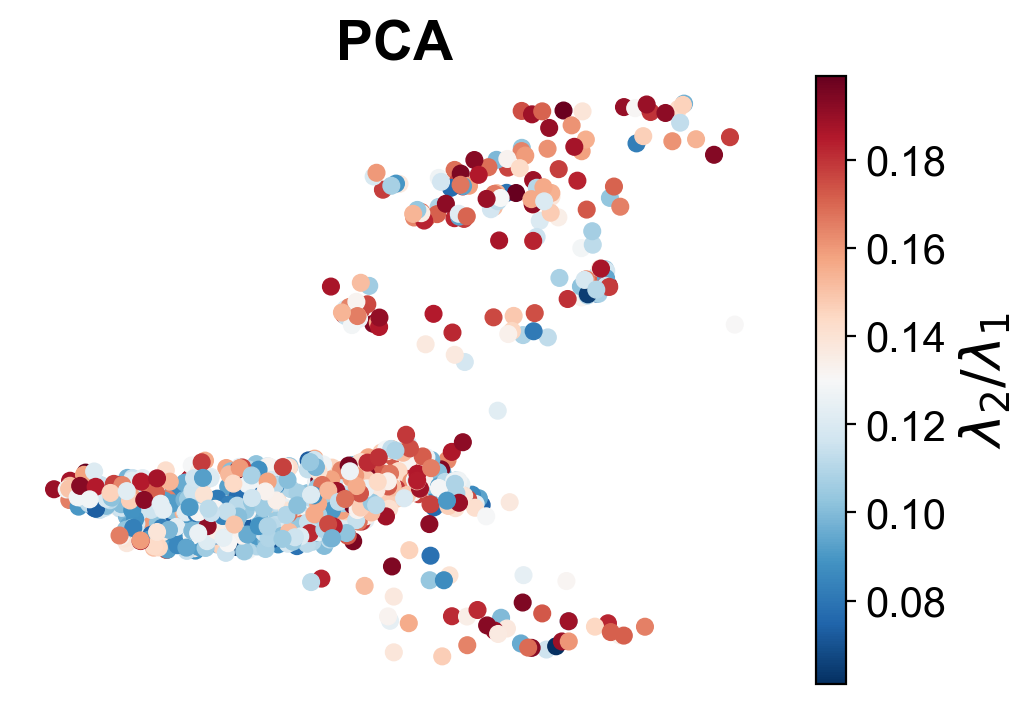

In [158]:
mask = np.where(max2_fs/max_fs<0.2)
plt.scatter(X_plt[mask],Y_plt[mask],c=(max2_fs/max_fs)[mask])
plt.axis('off')

#plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid,head_length=10*wid)
#plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=7*wid,head_length=7*wid)
#plt.text(X_ori+X_len/2,Y_ori-wid*15,'$UMAP_1$',fontsize=20,ha='center',weight='bold')
#plt.text(X_ori-wid*40,Y_ori+Y_len/2,'$UMAP_2$',fontsize=20,ha='center',weight='bold')
clb=plt.colorbar()
clb.ax.set_ylabel('$\lambda_2/\lambda_1$',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

#plt.savefig(figure_path+data_name+'_ratio.png',dpi=600,bbox_inches='tight')
plt.title('PCA',fontsize=20,weight='bold')
plt.show()

# plt.scatter(X_plt[:,0],X_plt[:,1],c=max3_fs/max2_fs)
# plt.colorbar()
# plt.show()

# plt.scatter(X_plt[:,0],X_plt[:,1],c=max3_fs/max_fs)
# plt.colorbar()
# plt.show()

In [159]:
fi_max = np.array([np.argmax(gene_gij[i]) for i in range(X.shape[0])])
gene_fi_max = np.array([gene_gij[i,int(fi_max[i])] for i in range(X.shape[0])])

fi_max_uni = np.unique(list(fi_max))
fi_max_num = np.zeros(fi_max_uni.shape[0])
for i in range(fi_max_uni.shape[0]):
    fi_max_num[i] = np.sum(fi_max==fi_max_uni[i])

fi_inds_max = fi_max_uni[np.argsort(fi_max_num)[-100:]]
fi_gene_max = gene_arr[fi_inds_max]

In [160]:
fi_min = np.array([np.argmin(gene_gij[i]) for i in range(X.shape[0])])
gene_fi_min = np.array([gene_gij[i,int(fi_min[i])] for i in range(X.shape[0])])

fi_min_uni = np.unique(list(fi_min))
fi_min_num = np.zeros(fi_min_uni.shape[0])
for i in range(fi_min_uni.shape[0]):
    fi_min_num[i] = np.sum(fi_min==fi_min_uni[i])

fi_inds_min = fi_min_uni[np.argsort(fi_min_num)[-100:]]
fi_gene_min = gene_arr[fi_inds_min]

In [161]:
X_fimax = Xs[:,fi_inds_max]
X_fimax_mean = np.mean(X_fimax,axis=0)
X_fimax_std = np.std(X_fimax,axis=0)
X_fimax_cv = X_fimax_std/X_fimax_mean

In [162]:
X_fimin = Xs[:,fi_inds_min]
X_fimin_mean = np.mean(X_fimin,axis=0)
X_fimin_std = np.std(X_fimin,axis=0)
X_fimin_cv = X_fimin_std/X_fimin_mean

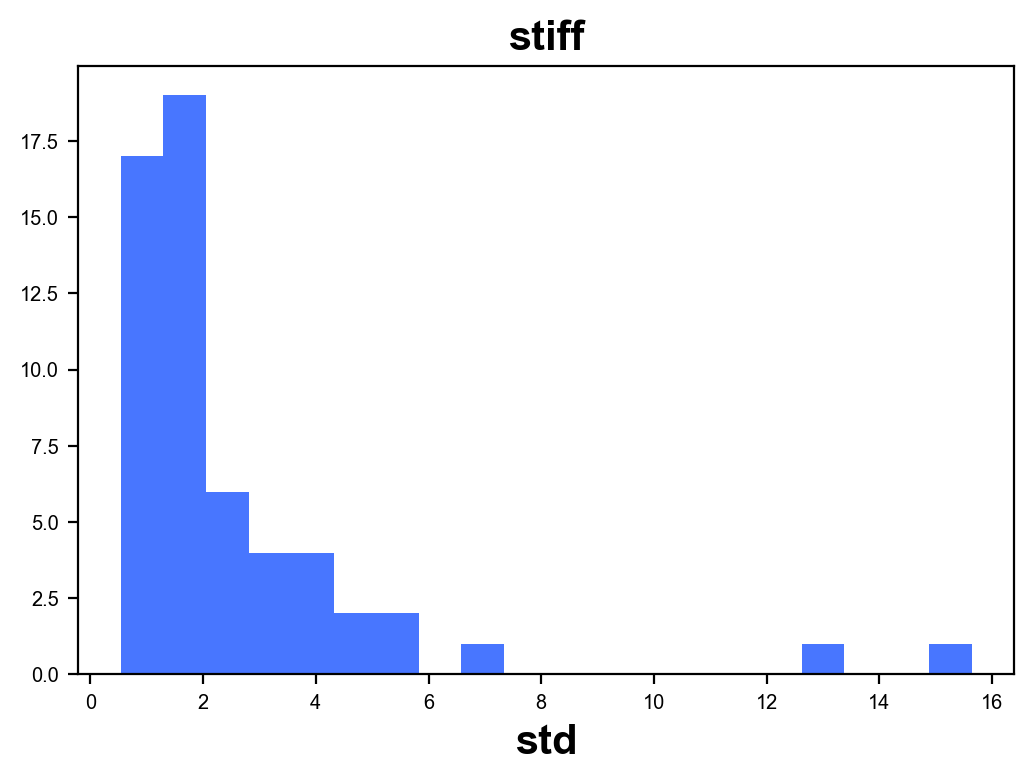

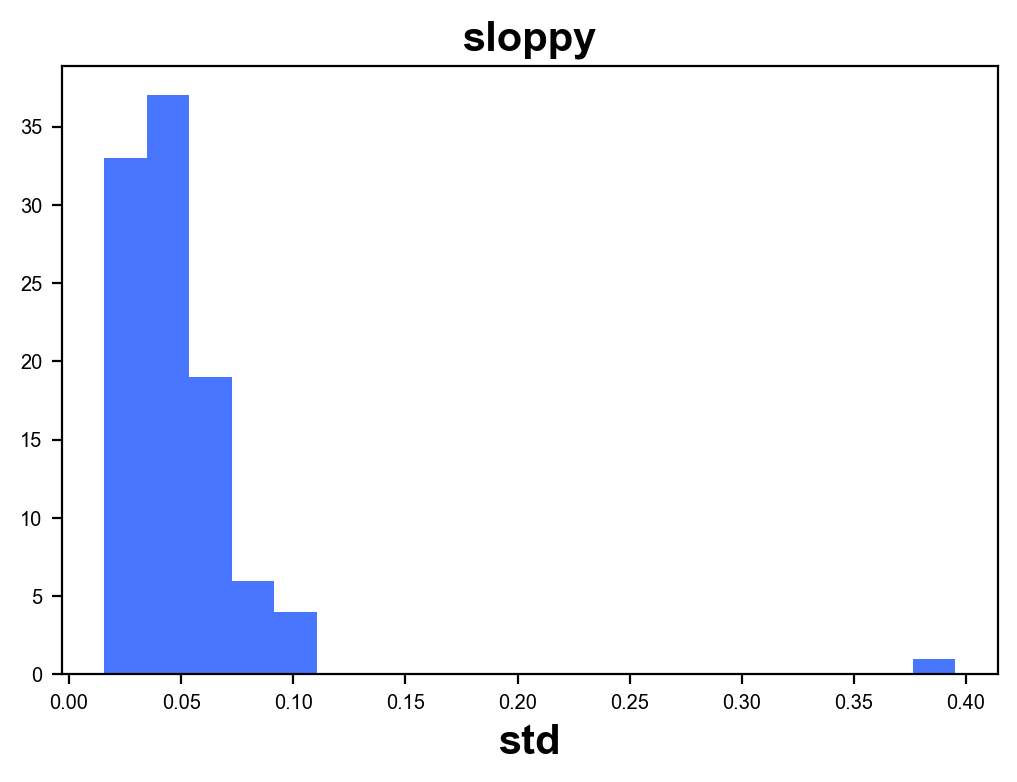

In [163]:
bins = 20

plt.hist(X_fimax_std,bins=bins)
plt.xlabel('std',fontsize=15,weight='bold')
plt.title('stiff',fontsize=15,weight='bold')
plt.show()

plt.hist(X_fimin_std,bins=bins)
plt.xlabel('std',fontsize=15,weight='bold')
plt.title('sloppy',fontsize=15,weight='bold')
plt.show()

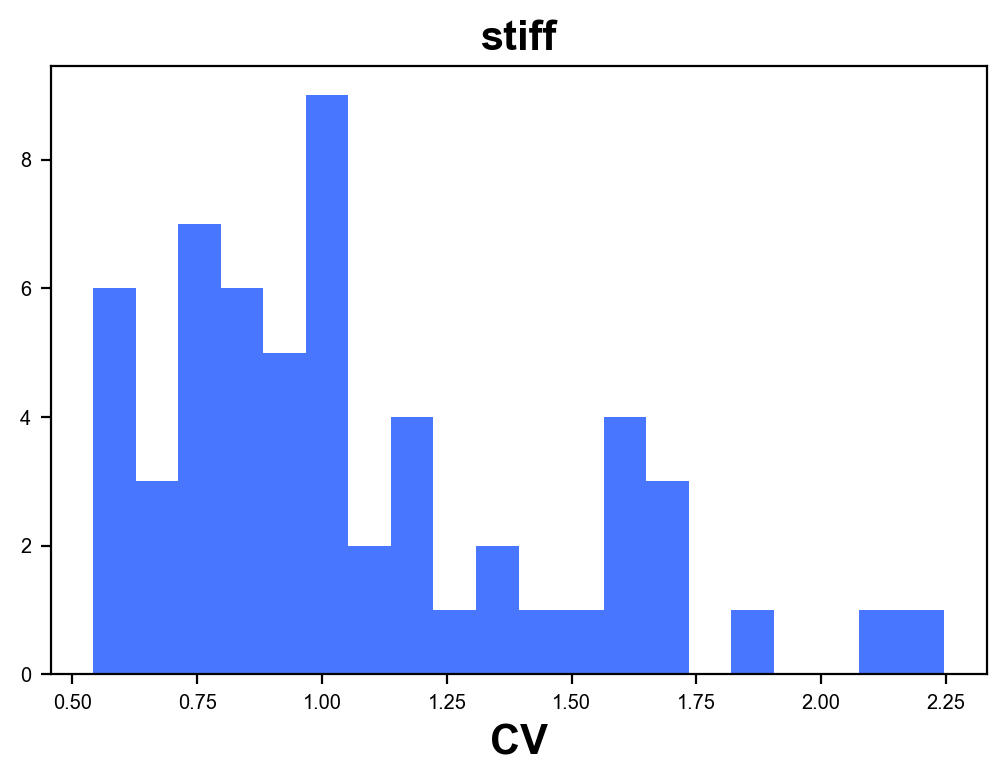

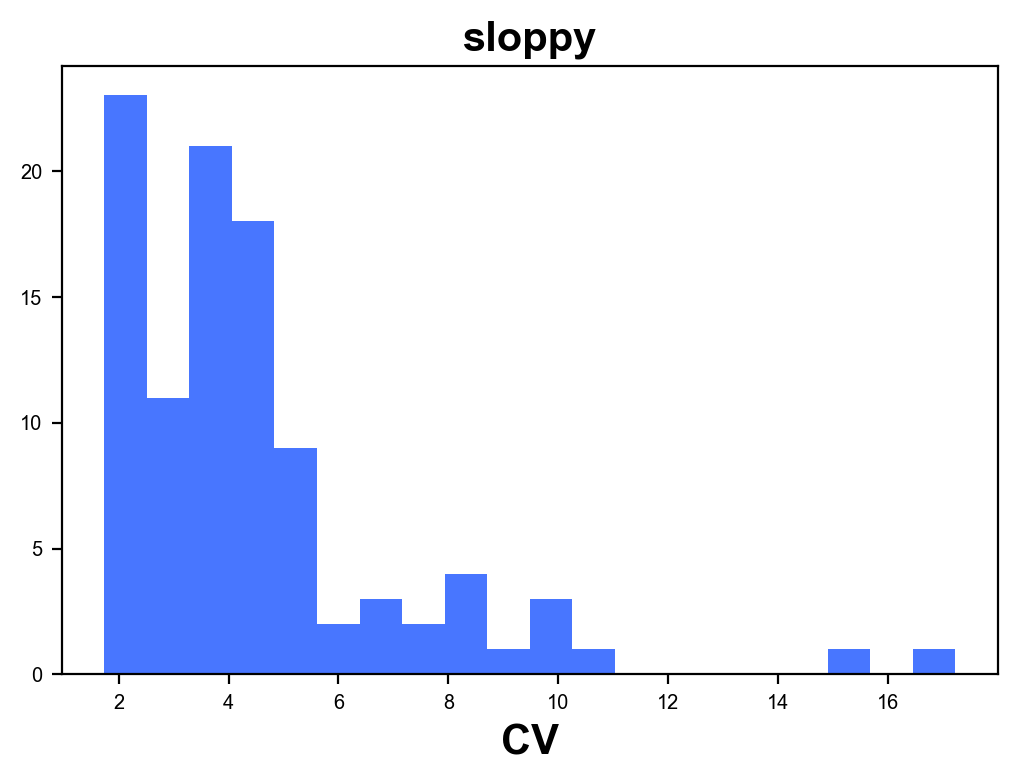

In [164]:
plt.hist(X_fimax_cv,bins=bins)
plt.xlabel('CV',fontsize=15,weight='bold')
plt.title('stiff',fontsize=15,weight='bold')
plt.show()

plt.hist(X_fimin_cv,bins=bins)
plt.xlabel('CV',fontsize=15,weight='bold')
plt.title('sloppy',fontsize=15,weight='bold')
plt.show()

In [165]:
def EigenIF(Fisher_g):
    n,L,_ = Fisher_g.shape
    #L=int(L/2)
    Eigenvalue = np.zeros((n,L))
    for i in range(n):
        Eigenvalue[i,:] = np.linalg.eigh(Fisher_g[i])[0]
    sorted_Eigenvalue = np.sort(Eigenvalue, axis=1)
    sorted_Eigenvalue = sorted_Eigenvalue[:, ::-1]
    relative_Eigenvalue = sorted_Eigenvalue[:,1:]/sorted_Eigenvalue[:,0].reshape(n,1)
    return Eigenvalue,sorted_Eigenvalue,relative_Eigenvalue

Eigenvalue,sorted_Eigenvalue,relative_Eigenvalue = EigenIF(g_pc)

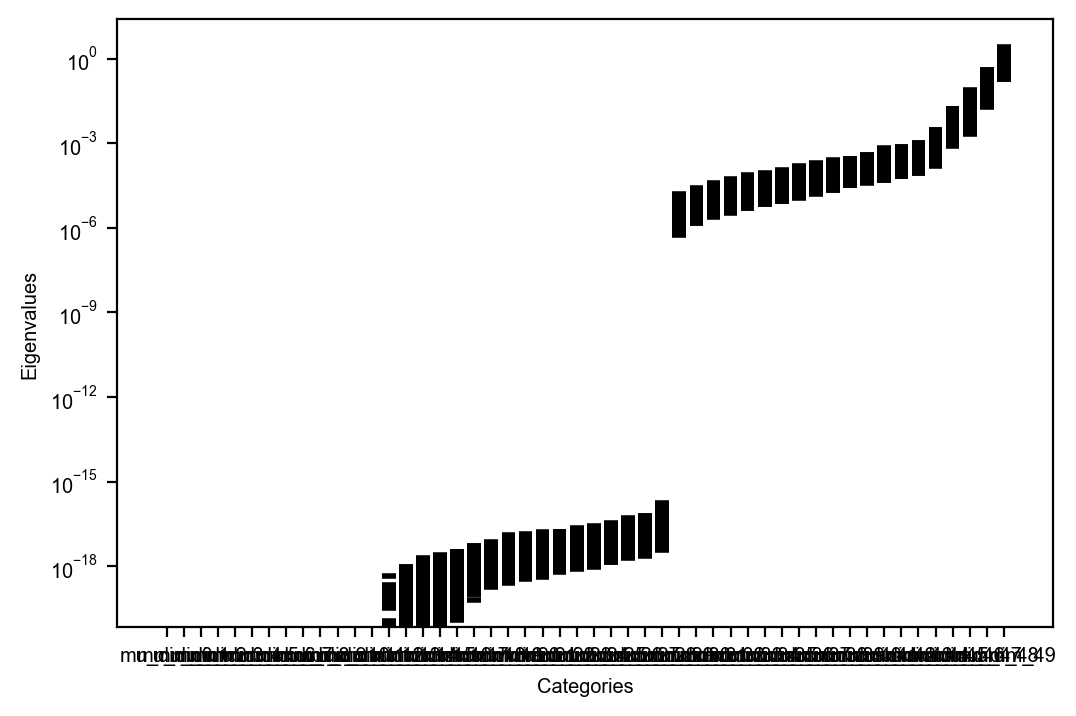

In [166]:
##各个维度特征值
categories = []
eigenvalues = {}
for i in range(Eigenvalue.shape[1]):
    categories.append(f'mu_dim_{i}')
    eigenvalues[f'mu_dim_{i}'] = Eigenvalue[:,i]

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2)

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)

ax.set_xlabel('Categories')
ax.set_ylabel('Eigenvalues')

plt.show()

In [167]:
##cluster 均值
clusters = adata.obs['Celltype']
categories = ['Differentiating GABA interneurons', 'GABA interneurons', 'Gliogenic progenitors', 'Neural stem cells', 'Proliferating VZ progenitors', 'VZ progenitors']
X_mean = np.mean(adata.X,axis=0)

eigenvalues = {}
g_pc_cl = {}
for i in categories:
    Xs_cl = np.mean(Xs[clusters==i],axis=0)
    mu, sigma = encoder(torch.tensor(Xs_cl))
    mu_cl = mu.detach().numpy()
    sigma_cl = sigma.detach().numpy()

    Fisher_g_cl=np.zeros((L*2,L*2))
    for j in range(L):
        Fisher_g_cl[j,j]=1/sigma_cl[j]**2
        Fisher_g_cl[L+j,L+j]=2/sigma_cl[j]**2

    X_cl = np.mean(adata.X[clusters==i],axis=0)
    X_pca_cl = (X_cl-X_mean)@adata.varm['PCs']

    pZ_pX_cl = np.zeros([L*2, X_pca.shape[1]])
    x0 = torch.tensor(X_pca_cl.astype(np.float32), requires_grad=True)
    z = model(x0)[0]
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pX_cl[j,:] = x0.grad.detach()

    g_pc_cl[i] = pZ_pX_cl.T @ Fisher_g_cl @ pZ_pX_cl
    eigenvalues[i] = np.linalg.eigh(g_pc_cl[i])[0]

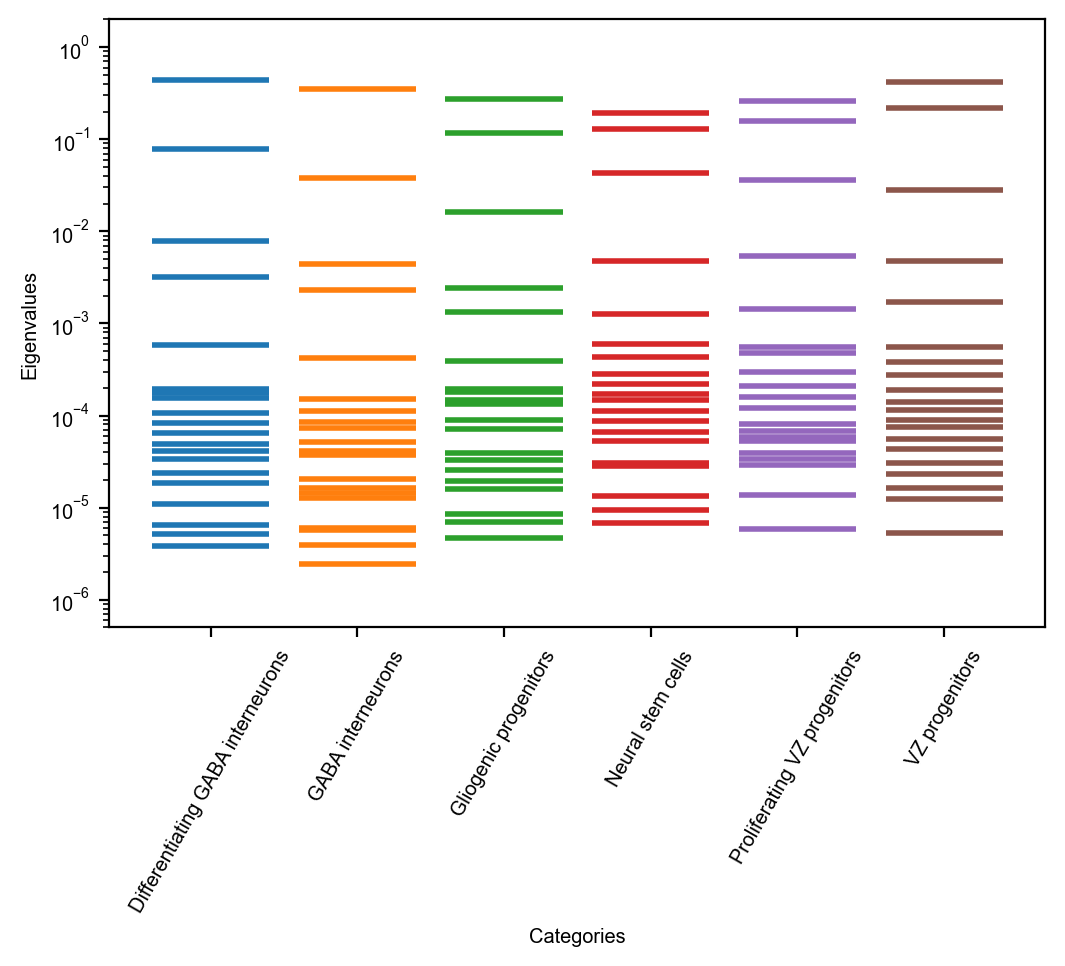

In [168]:
fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4, lw=2, color=adata.uns['Celltype_colors'][i])

ax.set_yscale('log')
ax.set_ylim(0.5*1e-6, 2*1e0)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)
plt.xticks(rotation=60)

ax.set_xlabel('Categories')
ax.set_ylabel('Eigenvalues')

plt.show()

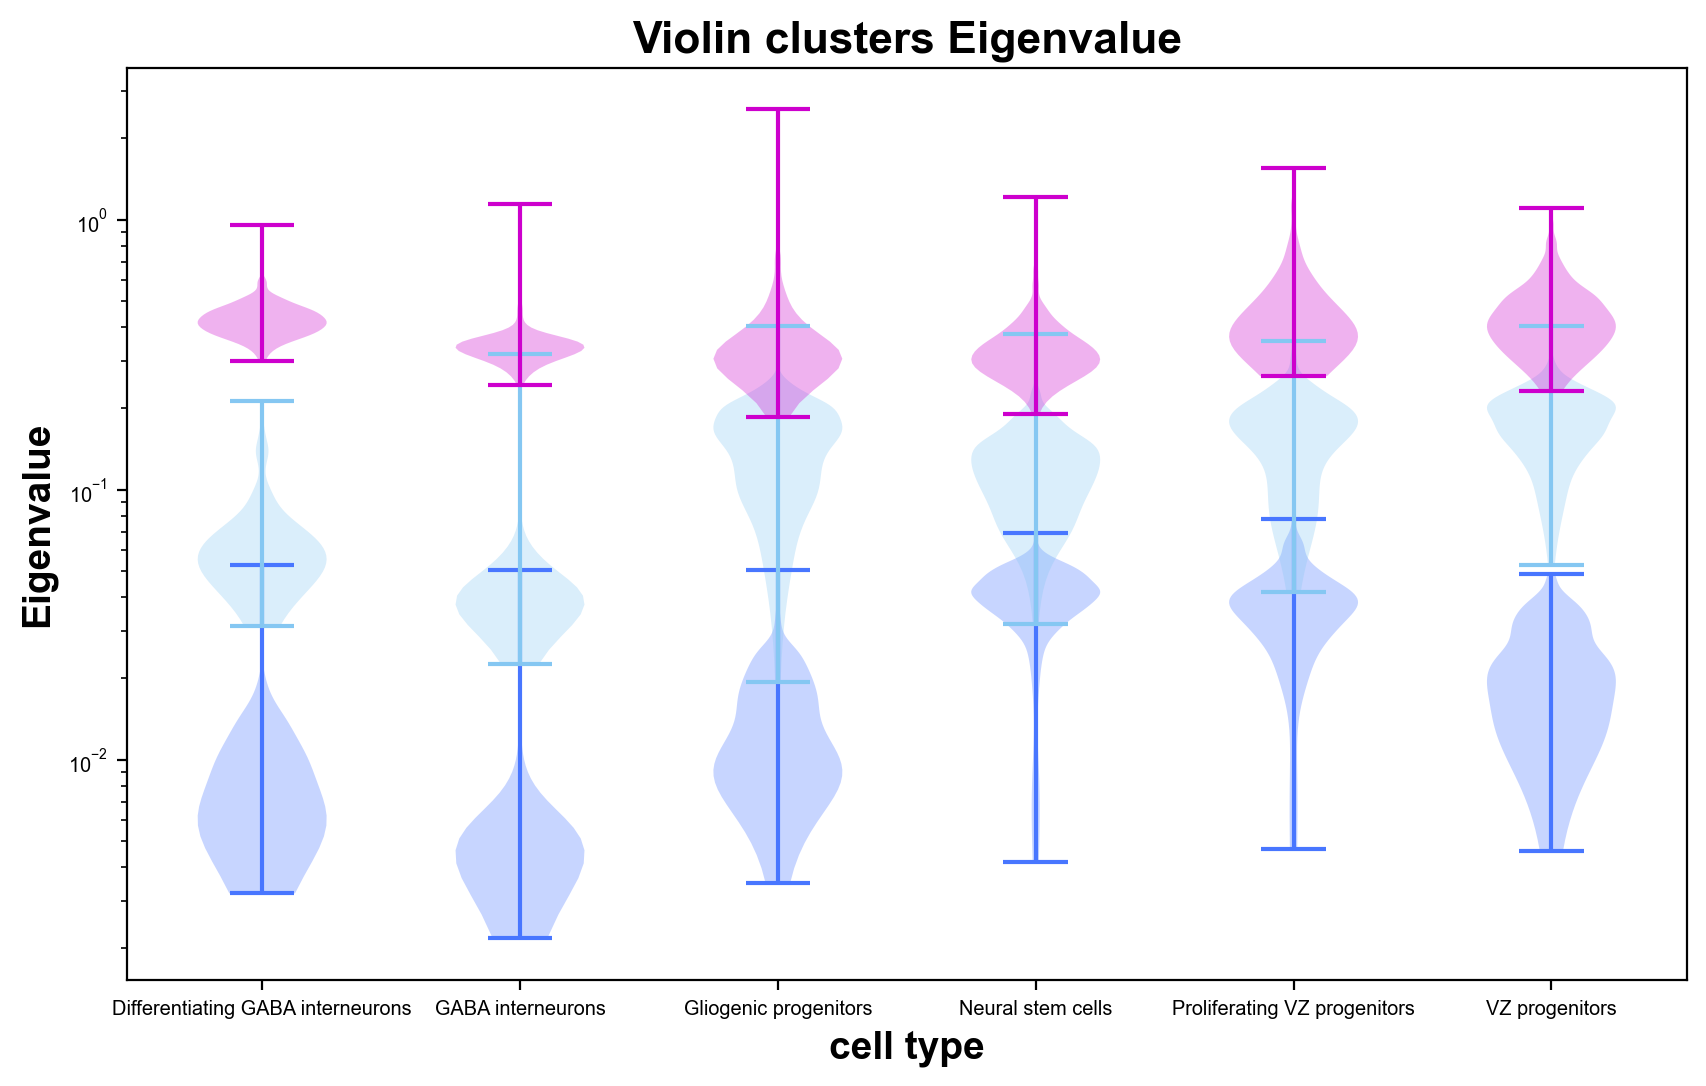

In [169]:
##不同颜色表示不同维度特征值
#categories = list(set(clusters[np.argsort(color_label)]))
#categories.sort(key = list(clusters[np.argsort(color_label)]).index)
#categories
eigenvalues = {}
eig_ind_max = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
    eig_mean = np.mean(eigenvalues[i],axis=0)
    eig_ind_max[i] = np.argsort(eig_mean)[-3:]
plt.figure(figsize=(10, 6))
#plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
#for j in range(L):
for j in range(3):
    plt.violinplot([eigenvalues[i][:,eig_ind_max[i][j]] for i in list(eigenvalues)])
# 设置x轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories)
if len(categories)>10:
    plt.xticks(rotation=40)
plt.yscale('log')
# 添加标题和标签
plt.title('Violin clusters Eigenvalue',fontsize=16,weight='bold')
plt.xlabel('cell type',fontsize=14,weight='bold')
plt.ylabel('Eigenvalue',fontsize=14,weight='bold')

plt.show()

In [196]:
eig_proj = {}
eig_var = {}
for i in categories:
    eig = np.linalg.eigh(g_pc_cl[i])
    eig_vec = eig[1].T
    eig_proj[i] = X_pca@eig_vec
    #eig_proj[i] = X_pca[clusters==i]@eig_vec
    eig_var[i] = np.std(eig_proj[i],axis=0)

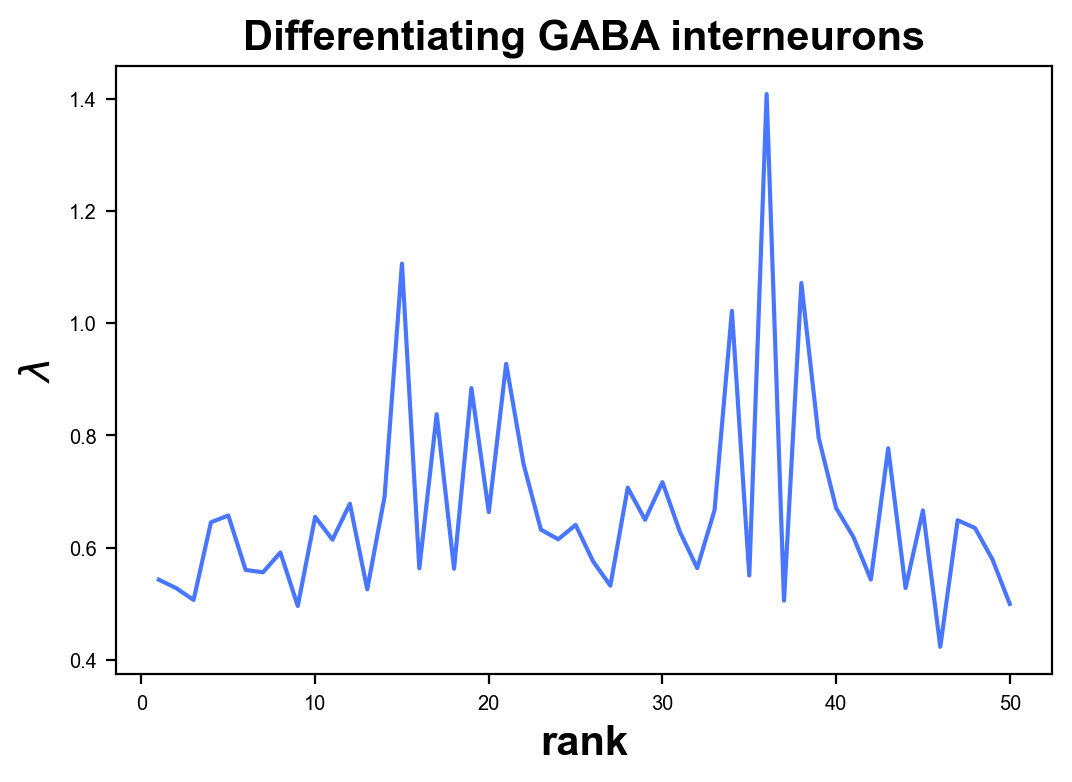

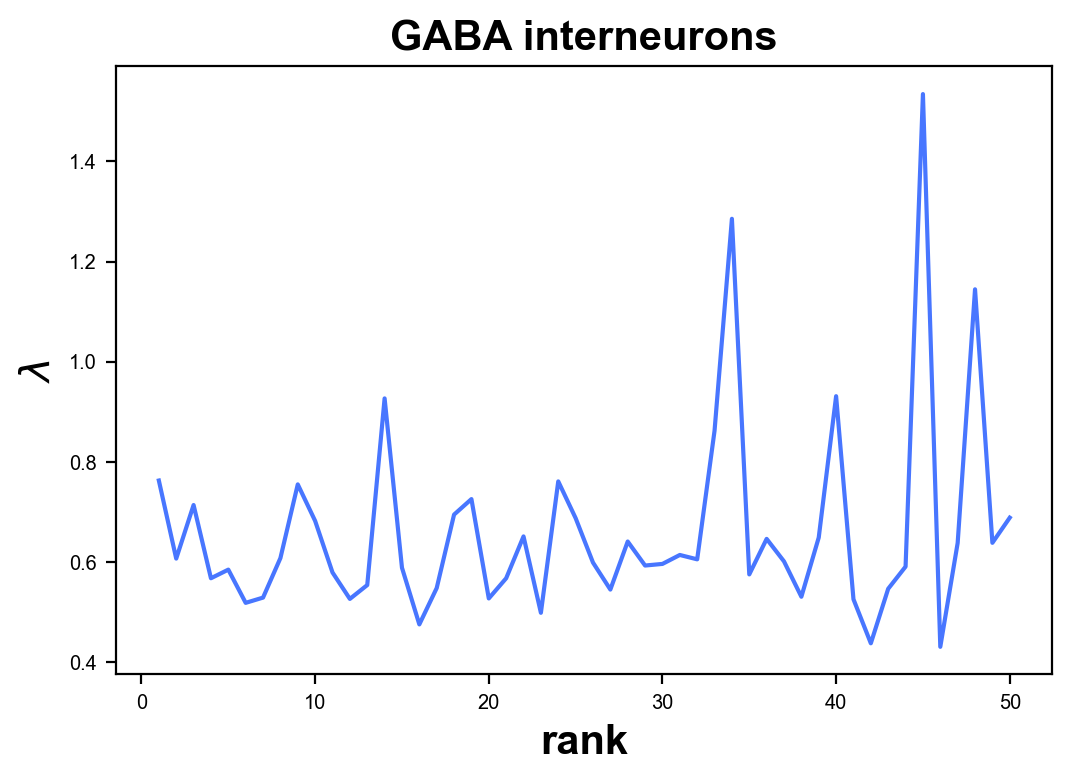

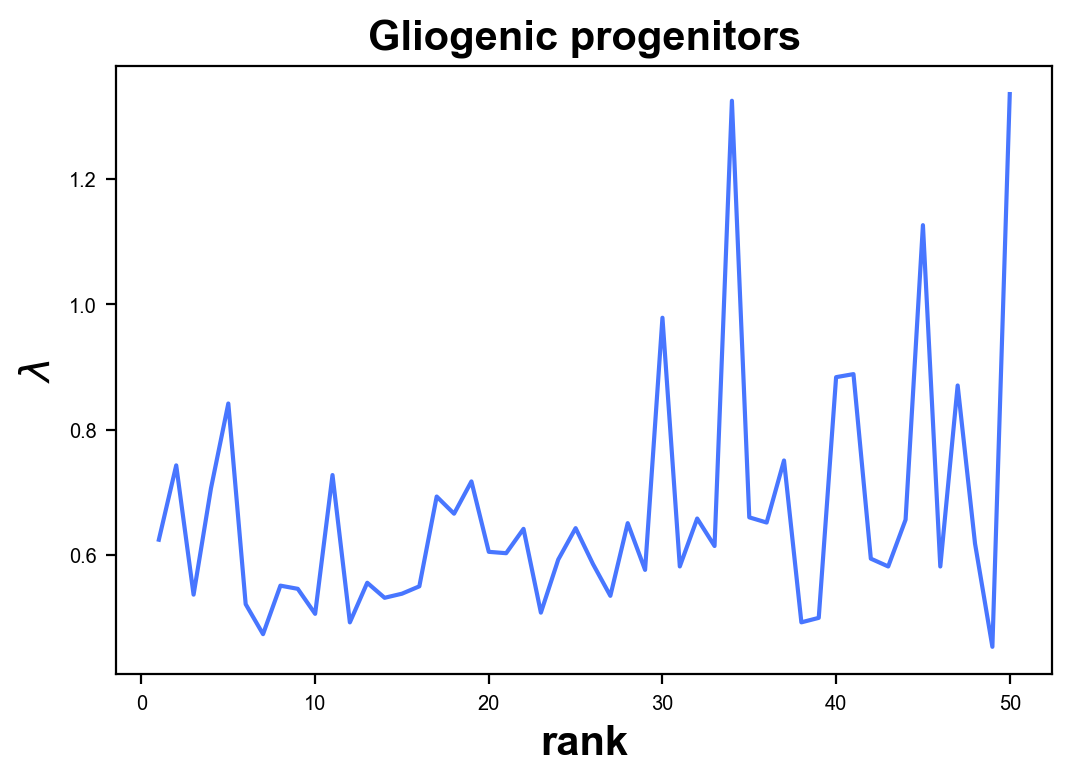

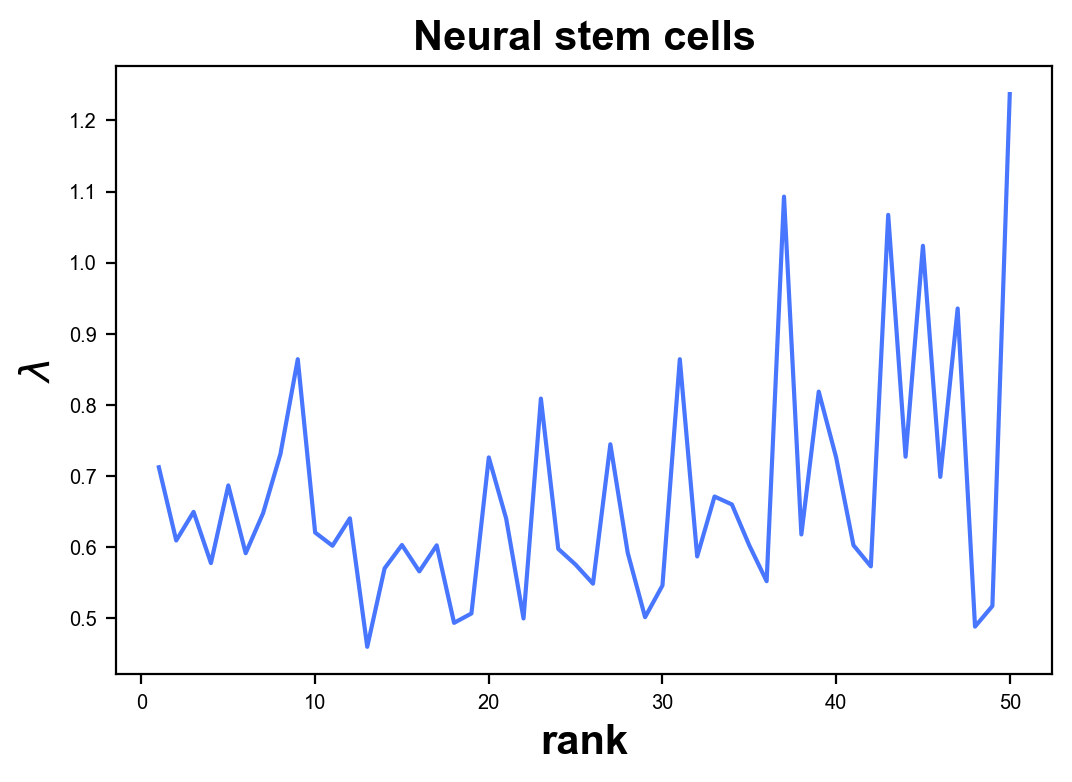

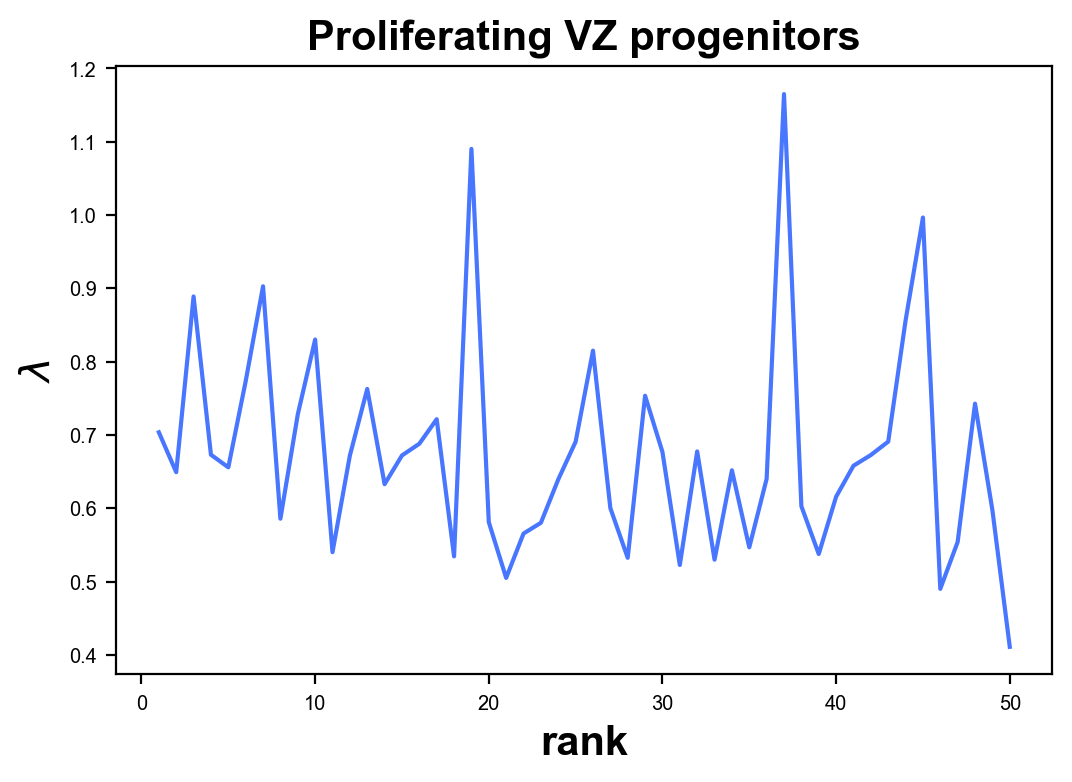

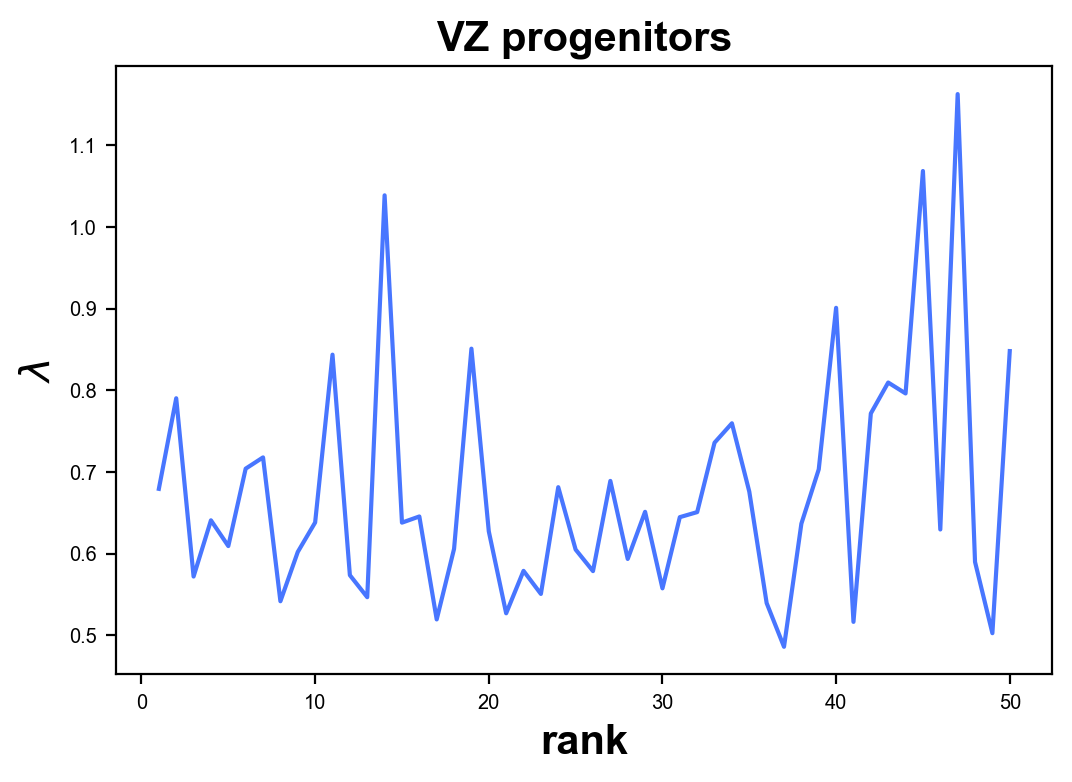

In [197]:
for i in categories:
    plt.plot(np.arange(X_pca.shape[1])+1,eig_var[i][::-1])
    plt.xlabel('rank',fontsize=15,weight='bold')
    plt.ylabel('$\lambda$',fontsize=15,weight='bold')
    plt.title(i,fontsize=15,weight='bold')
    plt.show()

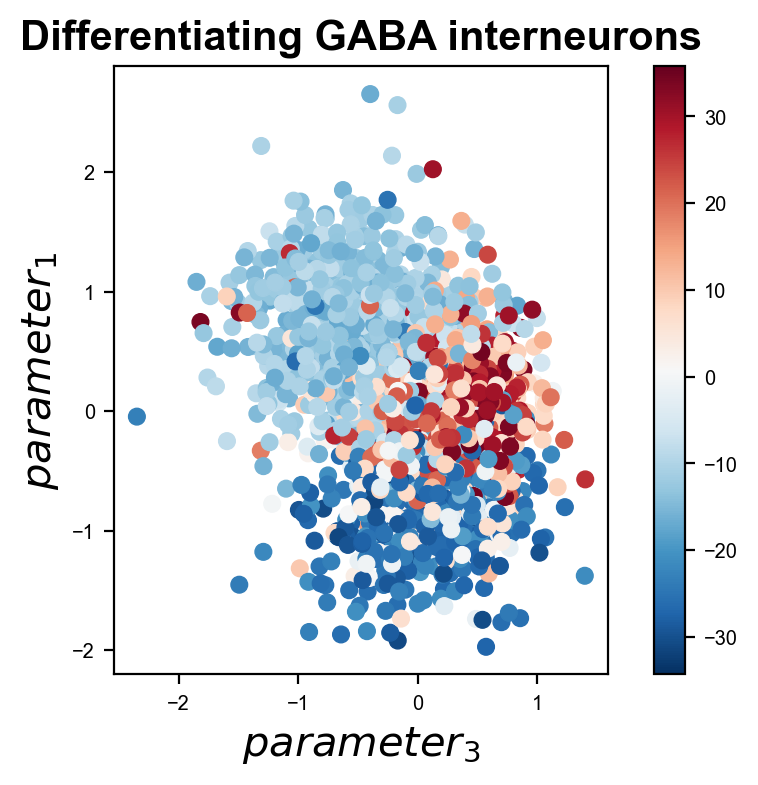

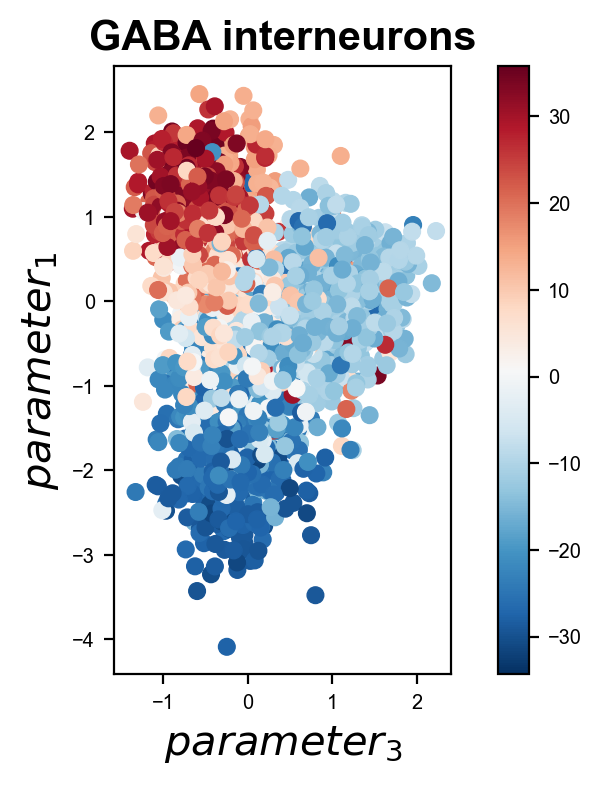

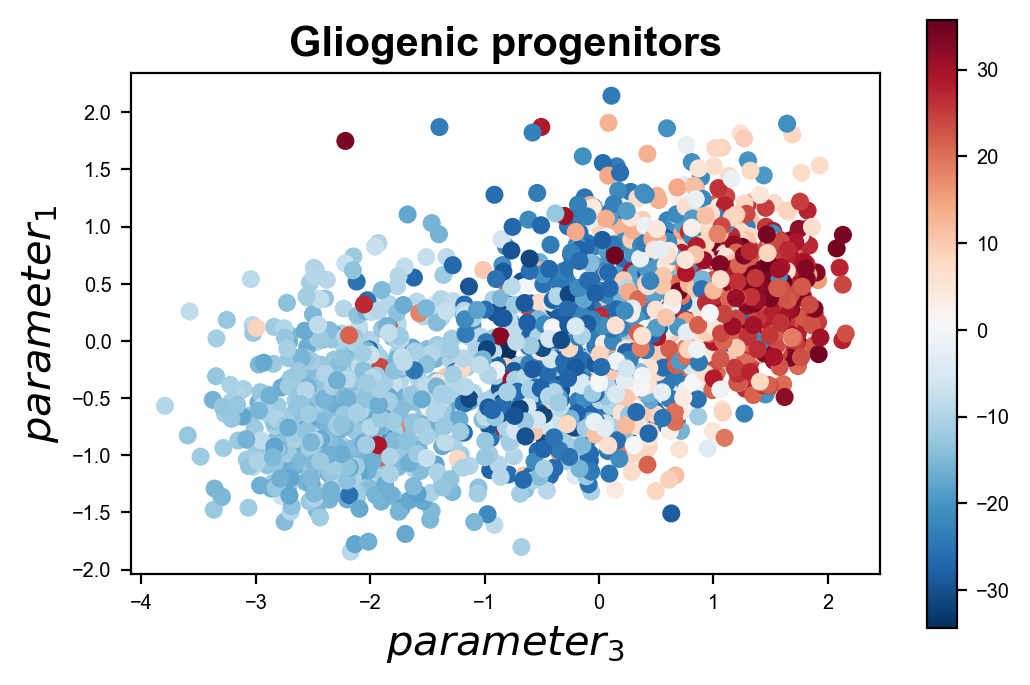

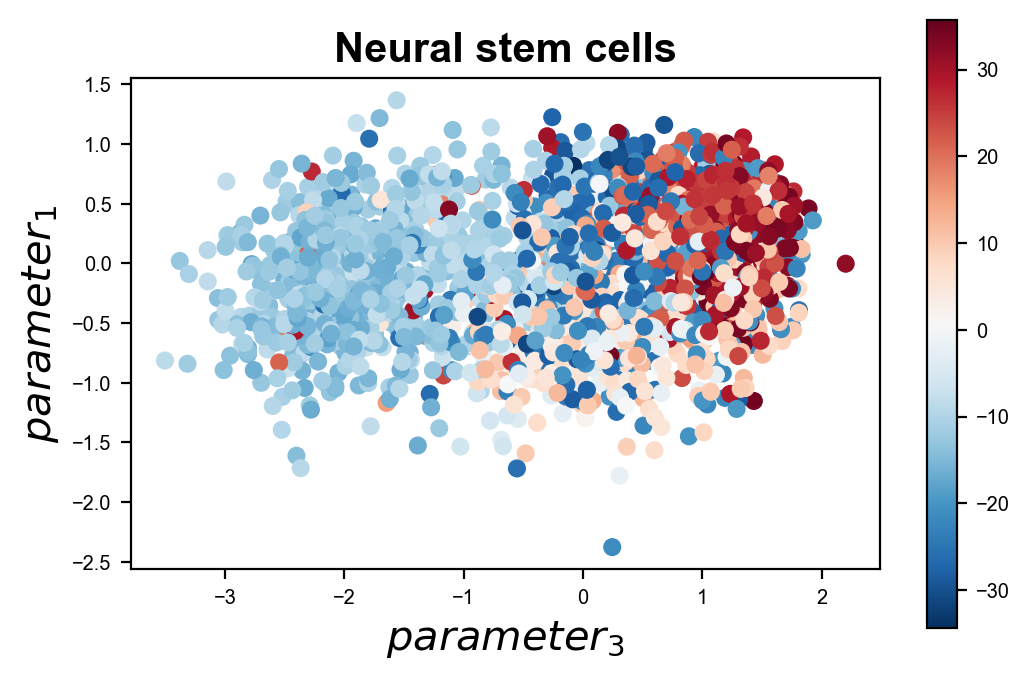

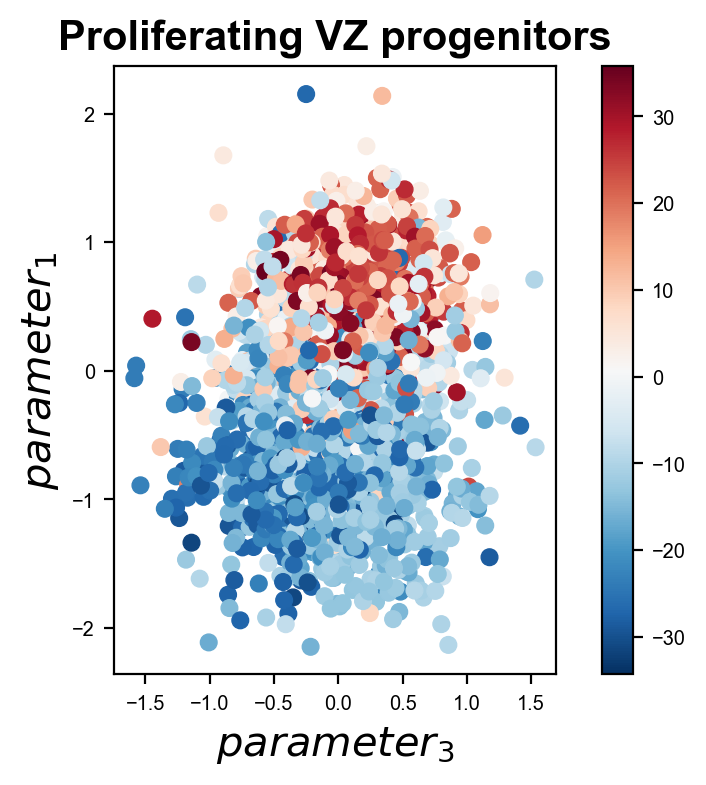

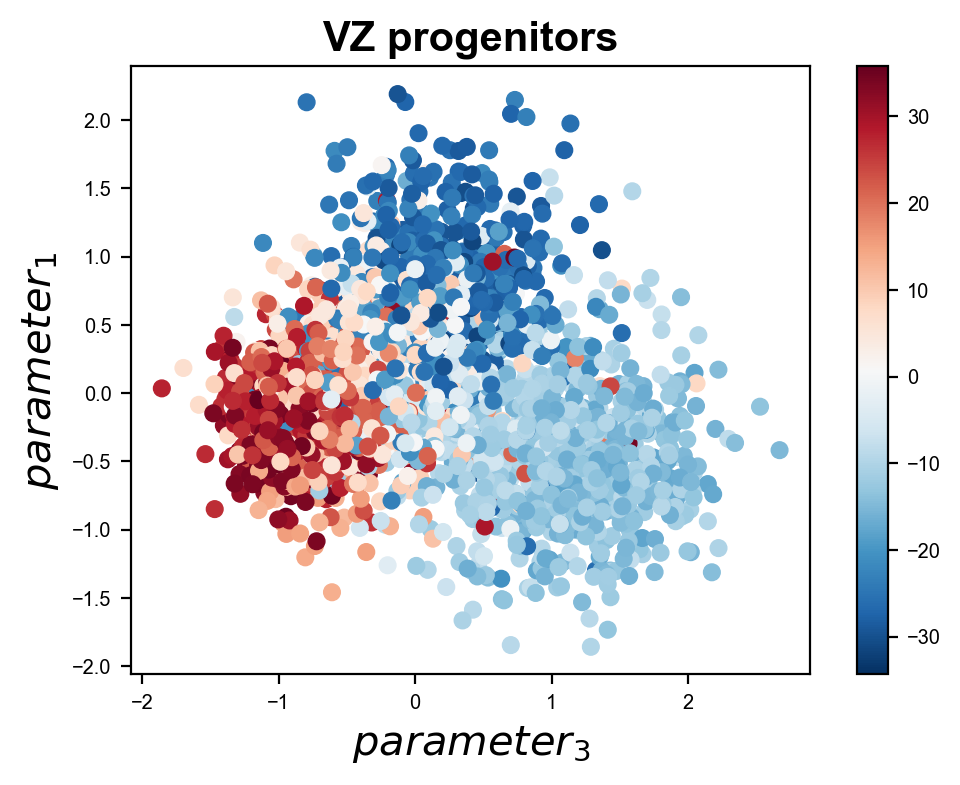

In [199]:
for i in categories:
    plt.scatter(eig_proj[i][:,0],eig_proj[i][:,2],c=X_tsne[:,1])#adata.obs['latent_time'])
    plt.xlabel('$parameter_3$',fontsize=15,weight='bold')
    plt.ylabel('$parameter_1$',fontsize=15,weight='bold')
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title(i,fontsize=15,weight='bold')
    plt.show()

In [183]:
adata.uns['Celltype_colors'][0]

'#1f77b4'

In [184]:
g_eig = [0]*X.shape[0]
for i in range(X.shape[0]):
    g_eig[i] = np.linalg.eigh(g_pc[i])

In [185]:
gij_eig = np.array([g_eig[i][0] for i in range(X.shape[0])])
gij_eig[np.where(gij_eig<0)] = 0
velo_eig = np.abs(np.array([(velo_pca[i]@g_eig[i][1]) for i in range(X.shape[0])]))
zv1_eig = np.array([np.sqrt(velo_eig[i]**2*gij_eig[i]) for i in range(X.shape[0])])

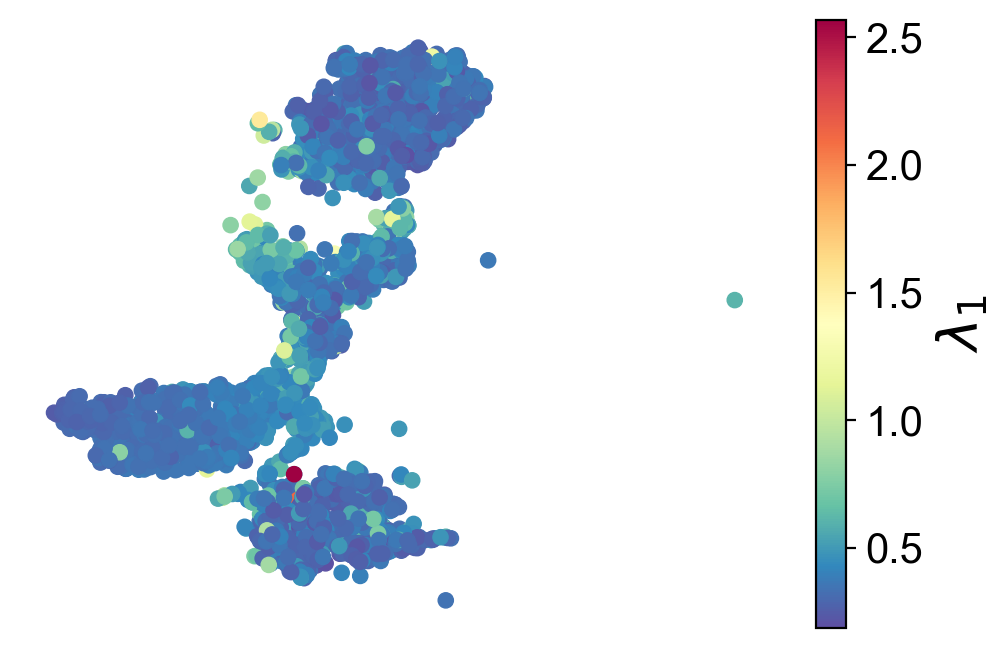

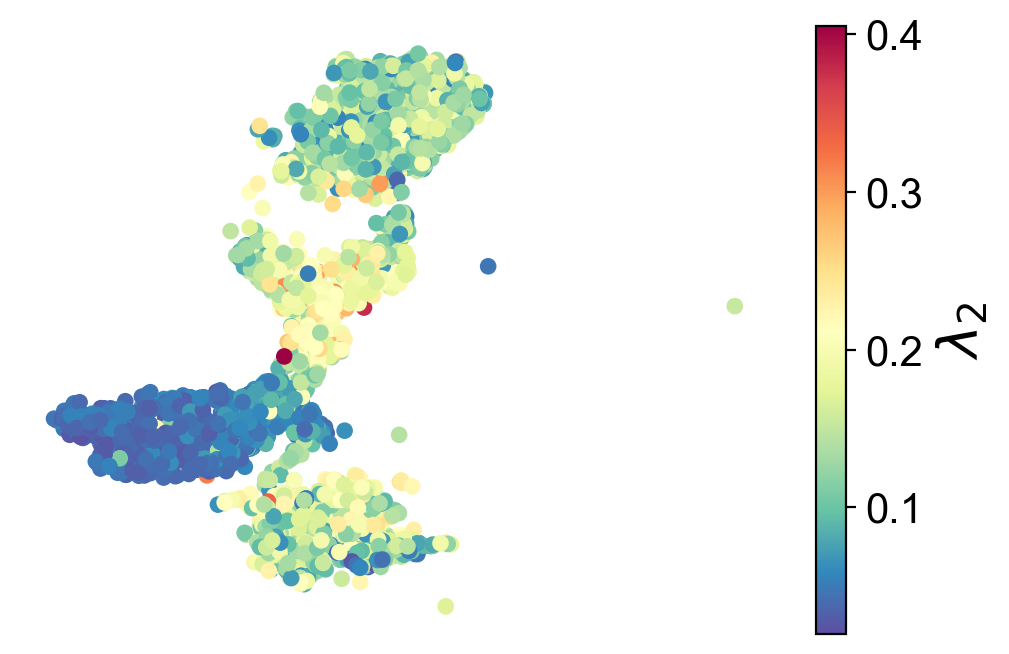

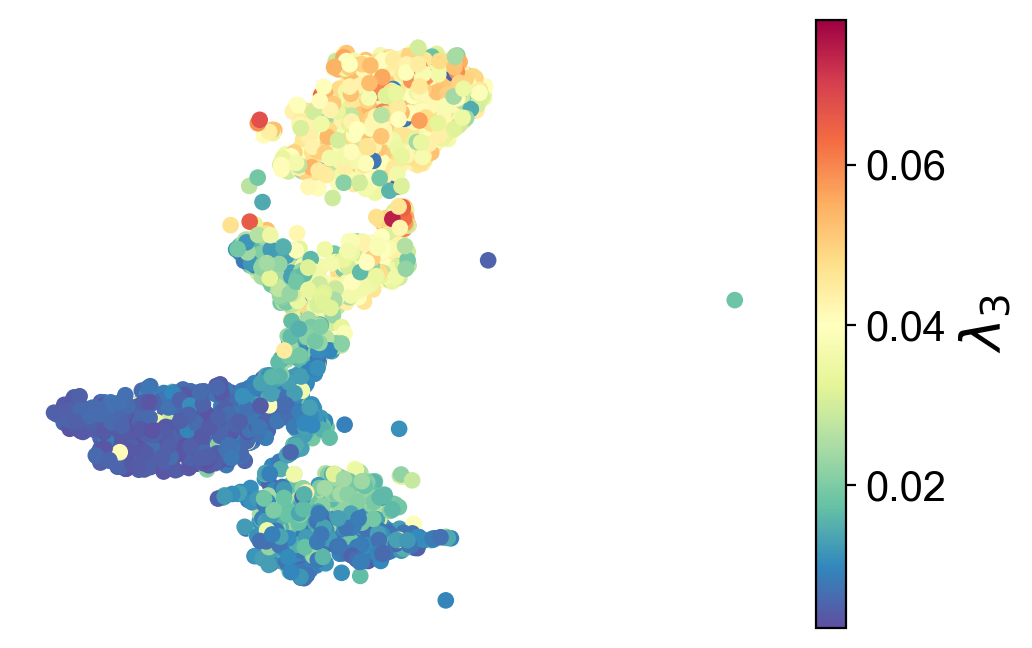

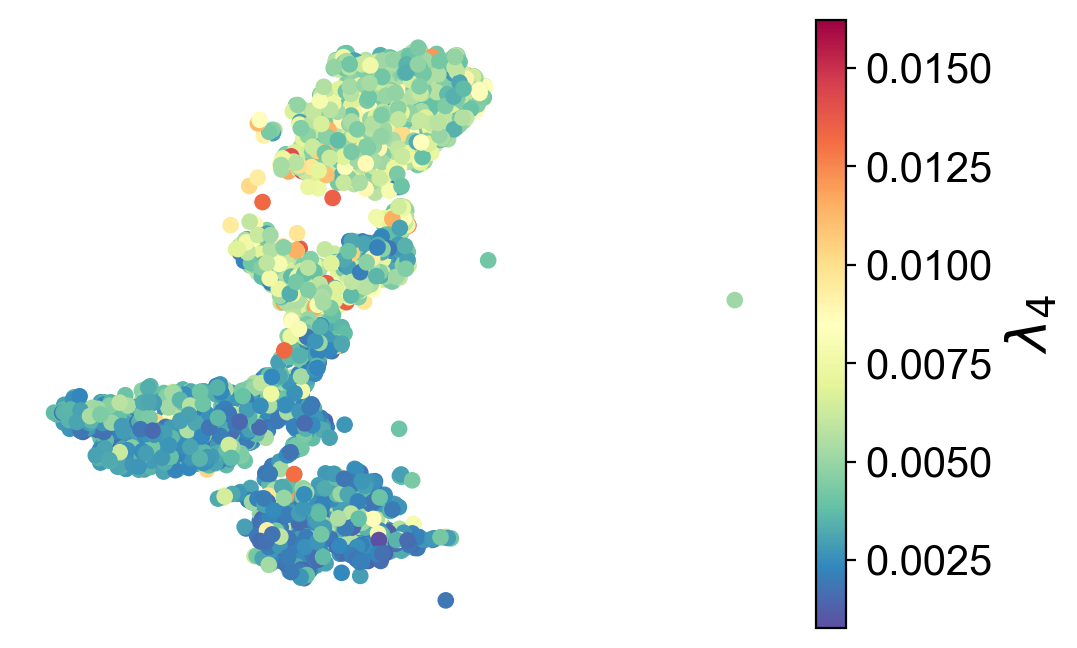

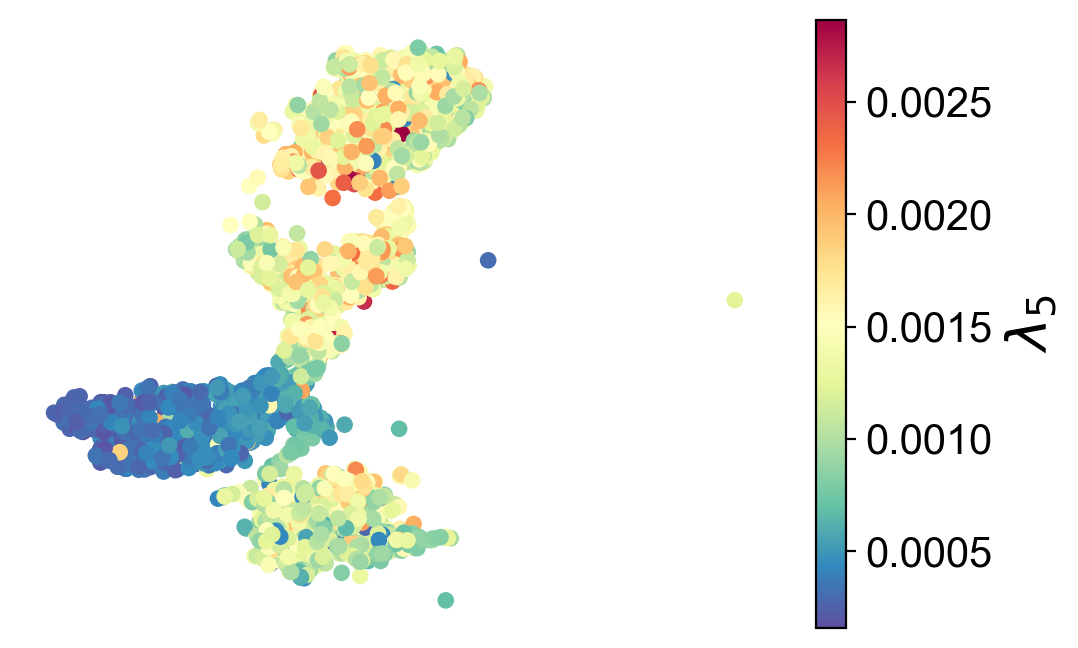

In [186]:
for i in range(5):
    plt.scatter(X_plt,Y_plt,c=gij_eig[:,-(i+1)],s=30,cmap=plt.colormaps['Spectral_r'])
    clb=plt.colorbar()
    clb.ax.set_ylabel('$\lambda_'+str(i+1)+'$',fontsize=20,weight='bold')
    clb.ax.tick_params(axis='y', labelsize=15)
    plt.axis('off')
    plt.show()

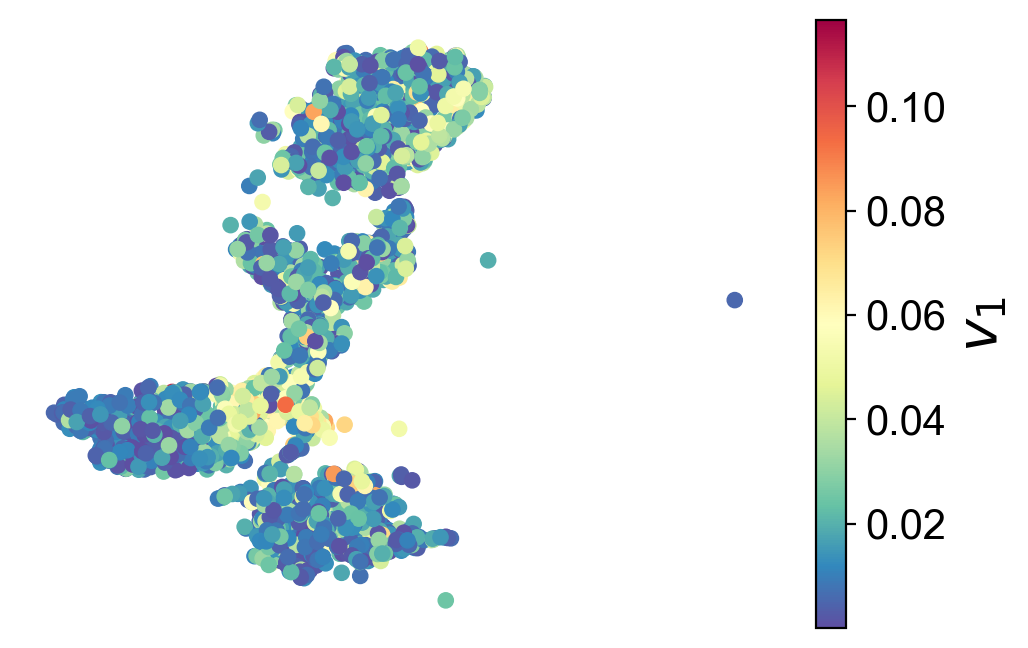

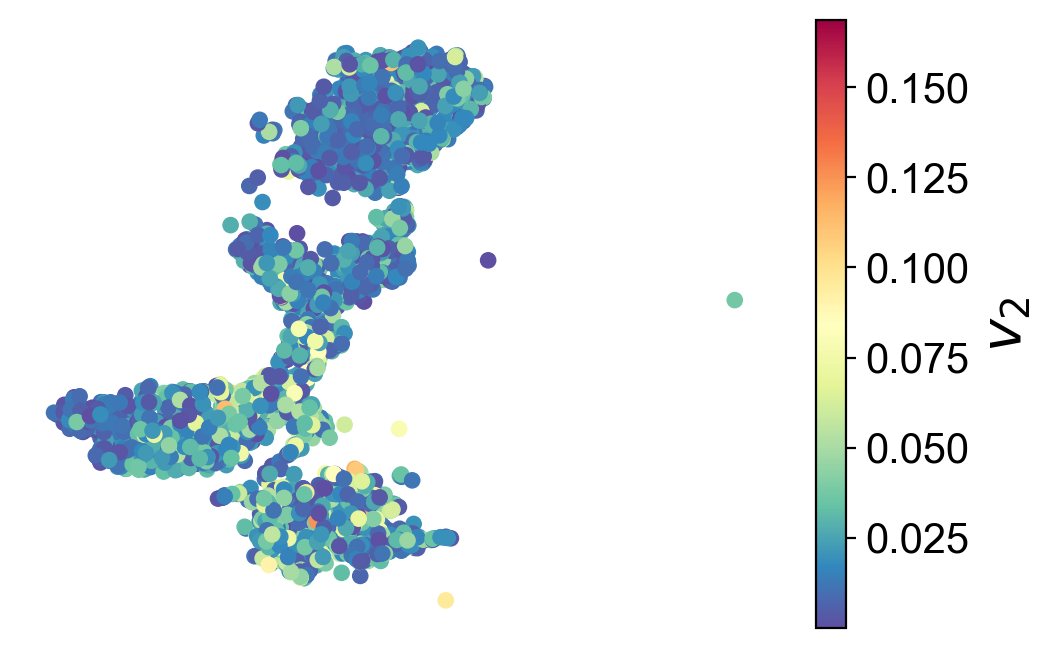

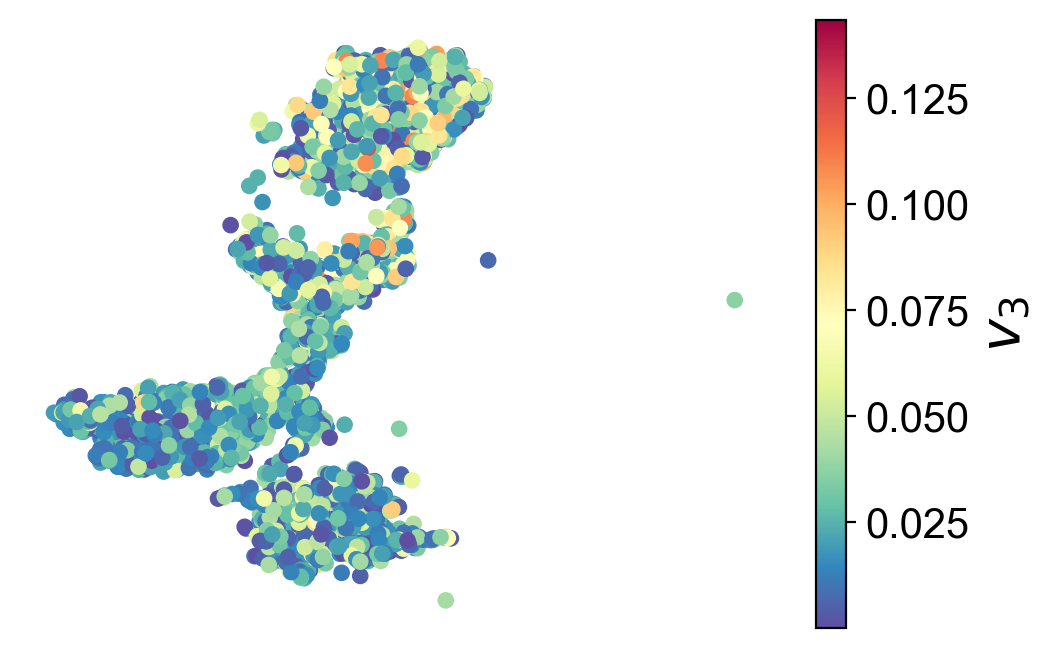

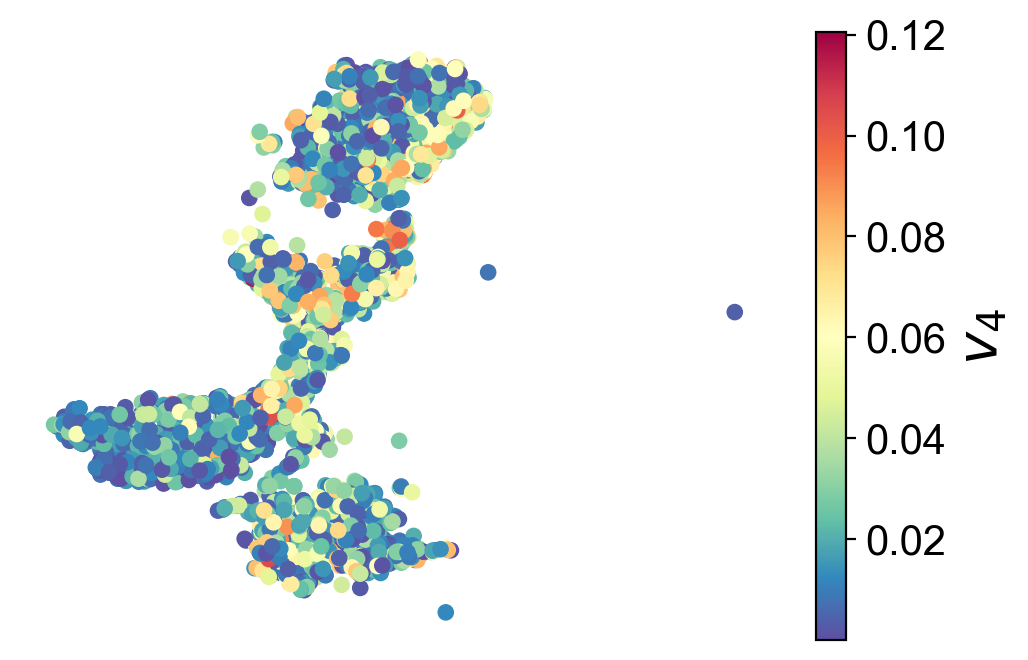

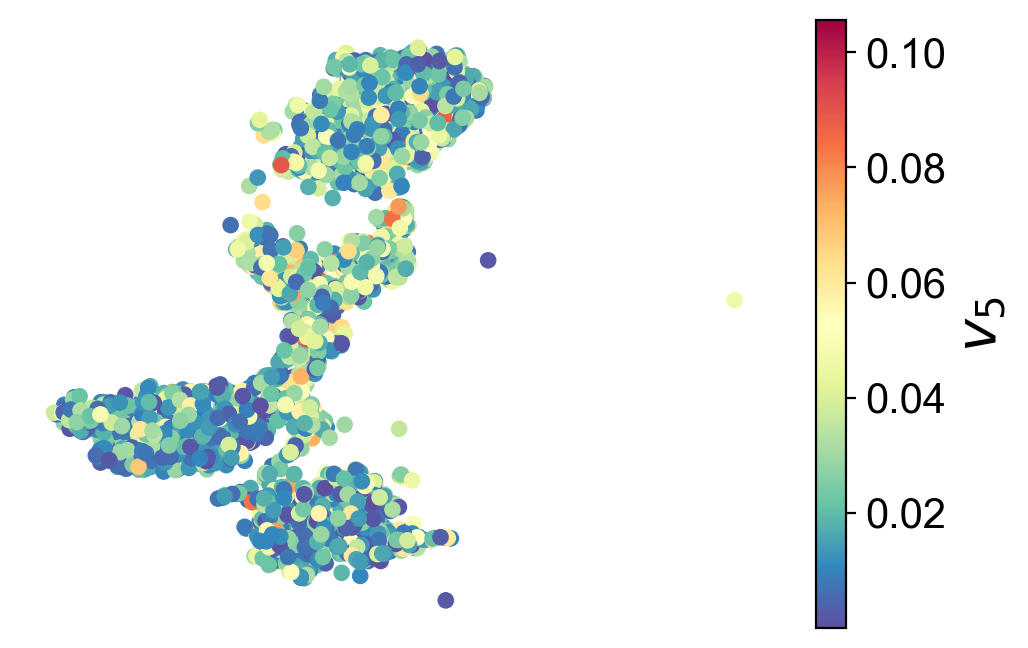

In [187]:
for i in range(5):
    plt.scatter(X_plt,Y_plt,c=velo_eig[:,-(i+1)],s=30,cmap=plt.colormaps['Spectral_r'])
    clb=plt.colorbar()
    clb.ax.set_ylabel('$v_'+str(i+1)+'$',fontsize=20,weight='bold')
    clb.ax.tick_params(axis='y', labelsize=15)
    plt.axis('off')
    plt.show()

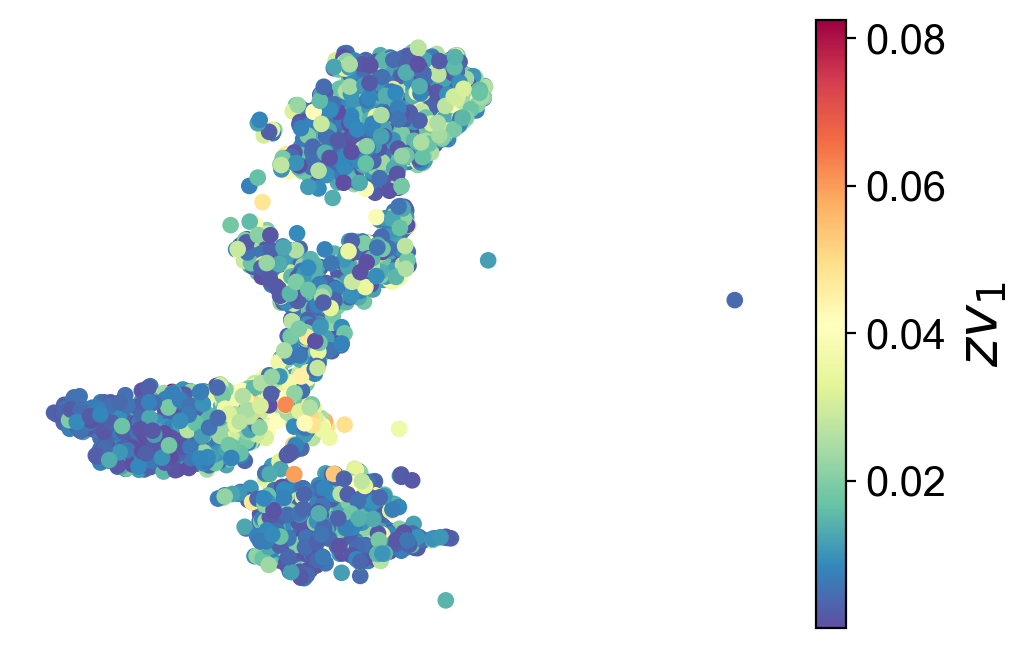

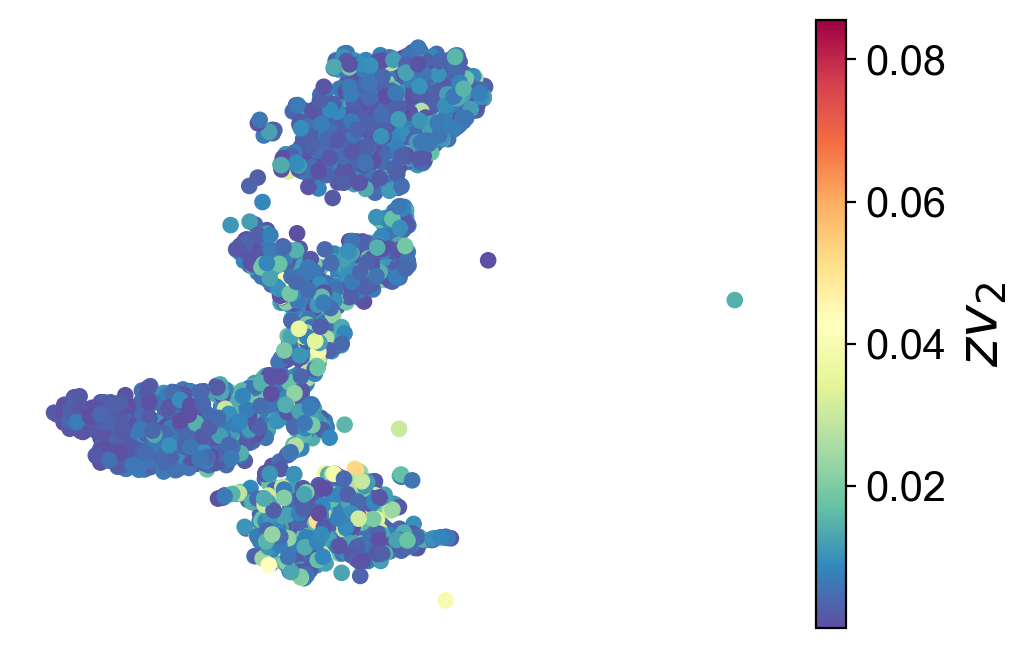

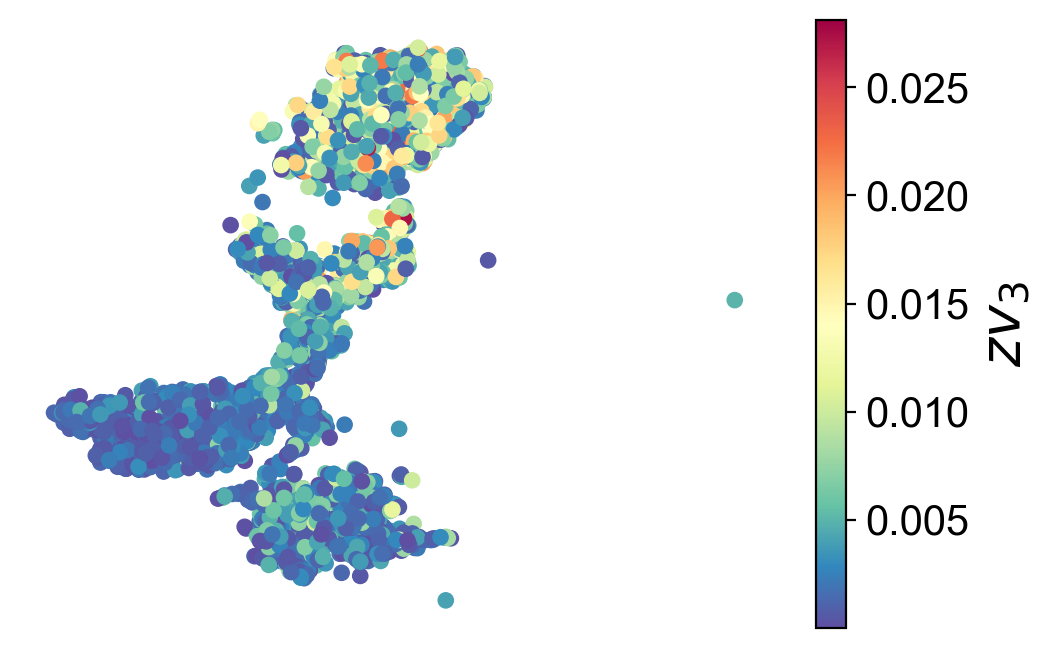

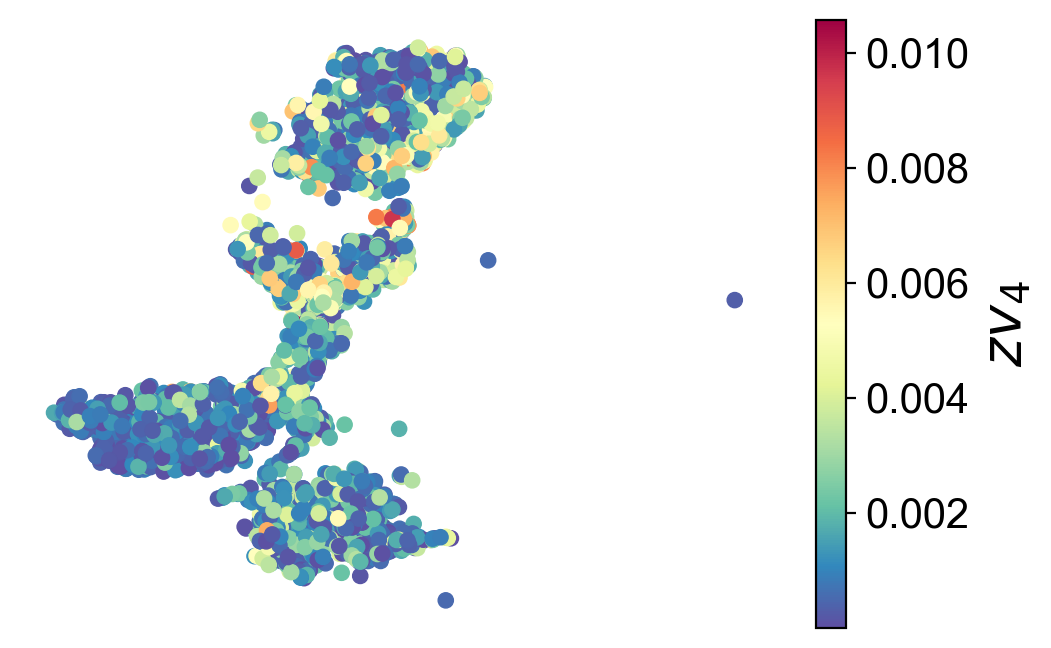

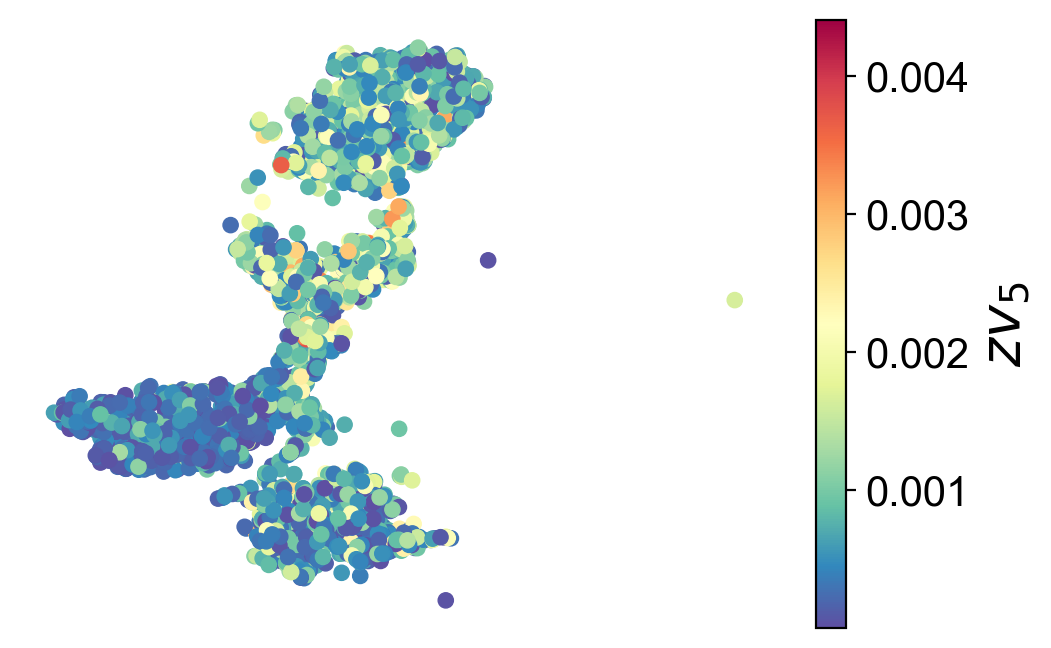

In [188]:
for i in range(5):
    plt.scatter(X_plt,Y_plt,c=zv1_eig[:,-(i+1)],s=30,cmap=plt.colormaps['Spectral_r'])
    clb=plt.colorbar()
    clb.ax.set_ylabel('$zv_'+str(i+1)+'$',fontsize=20,weight='bold')
    clb.ax.tick_params(axis='y', labelsize=15)
    plt.axis('off')
    plt.show()